In [1]:
%matplotlib notebook
import numpy as np
import re
import pandas as pd
import orbipy as op
import matplotlib.pyplot as plt
import pickle
import sympy as sp
import scipy as scp
import dill
import matplotlib

In [2]:
model = op.crtbp3_model()
precise_model = op.crtbp3_model()
precise_model.integrator.set_params(max_step=np.pi/180)
stm_model = op.crtbp3_model(stm=True)
plotter = op.plotter.from_model(model, length_units='km', velocity_units='m/s')
scaler = plotter.scaler

In [3]:
class CT:
    def __init__(self, model):
        self.c2 = self.c(2)
        self.mu = model.mu
        self.g = 1.-model.mu - model.L1
        self.w1 = sp.sqrt((self.c2 - 2 - sp.sqrt(9*self.c2**2 - 8*self.c2))/(-2))
        self.w2 = sp.sqrt(self.c2)
        self.l1 = sp.sqrt((self.c2 - 2 + sp.sqrt(9*self.c2**2 - 8*self.c2))/2)
        self.s1 = sp.sqrt(2*self.l1*((4 + 3*self.c2)*self.l1**2 + 4 + 5*self.c2 - 6*self.c2**2))
        self.s2 = sp.sqrt(self.w1*((4 + 3*self.c2)*self.w1**2 - 4 - 5*self.c2 + 6*self.c2**2))
    
    def c(self, n):
        g = sp.Symbol('g')
        mu = sp.Symbol('mu')
        return (mu+((-1)**n)*((1 - mu)*g**(n + 1))/((1 - g)**(n + 1)))/g**3

    def h(self, n):
        if n<=2:
            raise RuntimeError('n must be > 2')
        x,y,z = sp.symbols('x y z')
        sq = sp.sqrt(x**2+y**2+z**2)
        return -1*self.c(n)*sq**n*sp.together(sp.legendre(n, x/sq))
    
    def R(self):
        return sp.Matrix([[2*self.l1/self.s1,0,0,-2*self.l1/self.s1, 2*self.w1/self.s2,0],
                      [(self.l1**2-2*self.c2-1)/self.s1,(-self.w1**2-2*self.c2-1)/self.s2,0,(self.l1**2-2*self.c2-1)/self.s1,0,0],
                      [0,0,1/sp.sqrt(self.w2),0,0,0],
                      [(self.l1**2+2*self.c2+1)/self.s1,(-self.w1**2+2*self.c2+1)/self.s2,0,(self.l1**2+2*self.c2+1)/self.s1,0,0],
                      [(self.l1**3+(1-2*self.c2)*self.l1)/self.s1,0,0,(-self.l1**3-(1-2*self.c2)*self.l1)/self.s1,(-self.w1**3+(1-2*self.c2)*self.w1)/self.s2,0],
                      [0,0,0,0,0,sp.sqrt(self.w2)]]).subs({'g': ct.g, 'mu':ct.mu}).evalf()
    
    def symp_change(self):
        x,y,z,px,py,pz = sp.symbols('x1 y1 z1 px1 py1 pz1')
        mat = sp.Matrix([x,y,z,px,py,pz])
        return self.R()*mat
    
    def h_symp(self, n):
        x, y,z, px, py, pz = sp.symbols('x y z px py pz')
        change = self.symp_change()
        h = self.h(n)
        h = h.subs({'x': change[0], 'y': change[1], 'z': change[2]})
        h = h.subs({'x1': x, 'y1': y, 'z1': z, 'px1': px, 'py1': py, 'pz1': pz})
        h = h.subs({'g': ct.g, 'mu':ct.mu}).expand().evalf()
        return h
    
    def h_complex(self, n):
        y1,z1,py1,pz1 = sp.symbols('y1 z1 py1 pz1')
        y,z,py,pz = sp.symbols('y z py pz')
        sq2 = math.sqrt(2)
        y_change = (y1 + sp.I*py1)/sq2
        z_change = (z1 + sp.I*pz1)/sq2
        py_change = (py1 + sp.I*y1)/sq2
        pz_change = (pz1 + sp.I*z1)/sq2
        if n == 2:
            h = self.h2_symp()
        elif n>2:
            h = self.h_symp(n)
        else:
            raise RuntimeError('unsupported n')
        h = h.subs({'y': y_change, 'z': z_change, 'py': py_change, 'pz': pz_change}).expand()
        h = h.subs({'y1': y, 'z1': z, 'py1': py, 'pz1': pz})
        return h #self.chop(h)
    
    def gen_func(self, h_comp):
        x, y,z,px,py,pz = sp.symbols('x y z px py pz')
        n1 = self.l1.subs({'g': ct.g, 'mu':ct.mu}).evalf()
        n2 = sp.I*self.w1.subs({'g': ct.g, 'mu':ct.mu}).evalf()
        n3 = sp.I*self.w2.subs({'g': ct.g, 'mu':ct.mu}).evalf()
        pol = sp.Poly(h_comp, x,y,z,px,py,pz)
        mons = pol.monoms()
        gen = 0
        for mon in mons:
            a1 = (mon[3]-mon[0])
            a2 = (mon[4]-mon[1])
            a3 = (mon[5]-mon[2])
            if not (a1==0 and a2==0 and a3==0):
                denominator = a1*n1 + a2*n2 + a3*n3
                sym_part = x**mon[0]*y**mon[1]*z**mon[2]*px**mon[3]*py**mon[4]*pz**mon[5]
                coef = -1*pol.coeff_monomial(mon)
                gen += coef*sym_part/denominator
        return gen.expand()
    
    def pbracket(self, f, g):
        x, y,z, px, py, pz = sp.symbols('x y z px py pz')
        q = [x ,y ,z]
        p = [px, py, pz]
        res = 0
        for i in range(3):
            res += sp.diff(f, q[i])*sp.diff(g, p[i]) - sp.diff(f, p[i])*sp.diff(g, q[i])
        return res.expand()
    
    def h2(self):
        x, y,z, px, py, pz = sp.symbols('x y z px py pz')
        h = (self.c2*(-2*x**2 + y**2 + z**2) + 2*y*px - 2*x*py + px**2 + py**2 + pz**2)/2
        return h
    
    def h2_symp(self):
        change = self.symp_change()
        h = self.h2().subs({'x': change[0], 'y': change[1], 'z': change[2], 'px': change[3], 'py': change[4], 'pz': change[5]})
        x, y,z, px, py, pz = sp.symbols('x y z px py pz')
        h = h.subs({'x1': x, 'y1': y, 'z1': z, 'px1': px, 'py1': py, 'pz1': pz})
        h = h.subs({'g': ct.g, 'mu':ct.mu}).expand()
        return h #self.chop(h)
    
    def chop(self, h):
        x, y,z,px,py,pz = sp.symbols('x y z px py pz')
        pol = sp.Poly(h, x,y,z,px,py,pz)
        mons = pol.monoms()
        h_new = 0
#         import pdb; pdb.set_trace()
        for mon in mons:
            coef = pol.coeff_monomial(mon)
            coef_chopped = self.chop_coef(coef)
            a, b = coef_chopped.as_real_imag()
            if abs(a)+abs(b) > 0:
                sym_part = x**mon[0]*y**mon[1]*z**mon[2]*px**mon[3]*py**mon[4]*pz**mon[5]
                h_new += coef_chopped*sym_part
        
        return h_new
    
    def chop_coef(self, coef):
        a, b = coef.as_real_imag()
        new_coef = self.chop_num(a) + self.chop_num(b)*sp.I
#         print('Old coef: {}; New coef: {}'.format(coef, new_coef))
        return new_coef

    def chop_num(self, num, tol=1e-14):
        if abs(num) > tol:
            return num
        else:
            return 0
        
    def new_var(self, var, g, n):
        new_var = 0
        prev = 0
        new_var += var
        prev += new_var
        for i in np.arange(1, n+1):
            cur = self.pbracket(prev, g)
            new_var += cur/math.factorial(i)
            prev = cur.copy()
            
        return new_var.expand()#self.realify(new_var)
    
    
    def realify(self, expr):
        y1,z1,py1,pz1 = sp.symbols('y1 z1 py1 pz1')
        y,z,py,pz = sp.symbols('y z py pz')
        sq2 = math.sqrt(2)
        y_change = (y1 - sp.I*py1)/sq2
        z_change = (z1 - sp.I*pz1)/sq2
        py_change = (py1 - sp.I*y1)/sq2
        pz_change = (pz1 - sp.I*z1)/sq2
        
        real_expr = expr.subs({'y': y_change, 'z': z_change, 'py': py_change, 'pz': pz_change})
        real_expr = real_expr.subs({'y1': y, 'z1': z, 'py1': py, 'pz1': pz})
        
        return real_expr.expand()

In [4]:
class Hyperbolic:
    def __init__(self):
        self.c2 = self.calc_c2()
        self.lam = self.calc_lam()
        self.omega = self.calc_omega()
        self.k1 = self.calc_k1()
        self.k2 = self.calc_k2()
        self.k3 = self.calc_k3()
        self.k4 = self.calc_k4()
        
    def p1(self, state):
        (x, y) = state[:2]
        x -= model.L1
        (vx, vy) = state[3:5]
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) +\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def p1_table(self, orbit):
        x = orbit['x'].values - model.L1
        vx = orbit['vx'].values
        y = orbit['y'].values
        vy = orbit['vy'].values
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) +\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def p2_table(self, orbit):
        x = orbit['x'].values - model.L1
        vx = orbit['vx'].values
        y = orbit['y'].values
        vy = orbit['vy'].values
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) -\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def p2(self, state):
        (x, y) = state[:2]
        x -= model.L1
        (vx, vy) = state[3:5]
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) -\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def calc_vy(self, state):
        (x, y) = state[:2]
        x -= model.L1
        (vx, vy) = state[3:5]
        
        return (self.k3*self.omega*x+(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega)*(self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/self.k1
        
    def calc_c2(self):
        r1 = np.abs(model.L1+model.mu)
        r2 = np.abs(model.L1+model.mu-1)
        
        return (1.-model.mu)/r1**3+model.mu/r2**3
    
    def calc_lam(self):
        return np.sqrt((self.c2-2+np.sqrt(9*self.c2**2-8*self.c2))/2)
    
    def calc_omega(self):
        return np.sqrt((-1.*self.c2+2+np.sqrt(9*self.c2**2-8*self.c2))/2)
        
    def calc_k1(self):
        return -2/(self.c2+3+self.lam**2)
    
    def calc_k2(self):
        return -2/(2*self.c2+1-self.lam**2)
    
    def calc_k3(self):
        return (self.omega*(self.c2-1+self.lam**2))/((self.c2-1)*(self.c2+3+self.lam**2))
    
    def calc_k4(self):
        return (self.lam*(-2*self.c2+3+self.lam**2))/((self.c2-1)*(-2*self.c2-1+self.lam**2))

In [5]:
class CanonicTransform:
    def __init__(self, data_path, model, symp_mat_inverse):
        self.mu = model.mu
        self.gamma = 1.-model.mu-model.L1
        self.formula = dill.load(open(data_path, "rb"))
        self.symp_mat_inverse = symp_mat_inverse
        
    def symp_change(self, states):
        return (self.symp_mat_inverse @ states.transpose()).transpose()
        
    def apply_shift_scale(self, states):
        # 0-x 1-y 2-z 3-vx 4-vy 5-vz
        shift = (self.gamma+self.mu-1)/self.gamma
        states_new = states/self.gamma
        states_new[:,3] -= states[:,1]/self.gamma
        states_new[:,4] += states[:,0]/self.gamma
        states_new[:,0] += shift
        states_new[:,4] += shift
        return states_new
    
    def apply(self, states):
        arr = self.apply_shift_scale(states)
        arr = self.symp_change(arr)
        result = self.formula(arr[:,0],arr[:,1],arr[:,2],arr[:,3],arr[:,4],arr[:,5])
        return result

In [6]:
matplotlib.rcParams.update({'font.size': 20})

In [6]:
ct = CT(model)
symp_mat_inverse = np.linalg.inv(np.array(ct.R()).astype(np.float64))
ct_x3 = CanonicTransform('./x32.bin', model, symp_mat_inverse)

In [7]:
def calc_orb(dx, dz):
    s0 = model.get_zero_state()
    s0[0] = model.L1 + dx
    s0[2] = dz
    EL1_dist = 1.-model.mu - model.L1
    left = op.eventX(model.L1-EL1_dist)
    right = op.eventX(1.-model.mu)
    corr = op.border_correction(model, op.y_direction(), left, right)
    sk = op.simple_station_keeping(precise_model, corr, corr)
    orb = sk.prop(0.0, s0, 20)
    return orb.to_numpy(), sk.dvout

In [8]:
class CTProp:
    def __init__(self, model, formula_path):
        self.model = model
        ct = CT(model)
        symp_mat_inverse = np.linalg.inv(np.array(ct.R()).astype(np.float64))
        self.ct_x3 = CanonicTransform(formula_path, model, symp_mat_inverse)
        self.log = []
        self.time_log = []
        
    def target(self, dvy, state):
        s1 = state.copy()
        s1[4] += dvy
        return self.ct_x3.apply(np.array([s1]))[0]
        
    def correct(self, state):
        bound = self.bound(state)
        dvy = scp.optimize.bisect(self.target,-1.*bound, bound, xtol=1e-14, args=(state,))
        self.log.append(dvy)
        return dvy
    
    def bound(self, state):
        bound = 1e-13
        
        for i in range(13):
            if self.bound_crit(state, bound)<0:
                return bound
            else:
                bound*=10
        raise Exception('no root')
            
    def bound_crit(self, state, dv):
        val1 = self.target(dv, state)
        val2 = self.target(-1.*dv, state)
        return val1*val2
    
    def prop(self, dx, dz, N=10, time_step=np.pi):
        self.log = []
        self.time_log = []
        s0 = self.model.get_zero_state()
        s0[0] = self.model.L1 + dx
        s0[2] = dz
        result = []
        part, s0, t0 = self.prop_step(s0, 0.0, 0.0+time_step)
        result.append(part)
        for i in range(N-1):
            part, s0, t0 = self.prop_step(s0, t0, t0+time_step)
            result.append(part)
        return np.vstack(result)
        
    def prop_step(self, s0, t0, t1):
        s1 = s0.copy()
        s1[4] += self.correct(s1)
        self.time_log.append(t0)
        orb_part = self.model.prop(s1, t0, t1, ret_df = False)
        return orb_part[:-1], orb_part[-1][1:], orb_part[-1][0]
    
    def unst_comp_graph(self, orb, cor_times):
        orb_states = orb[:,1:].copy()
        orb_x3 = self.ct_x3.apply(orb_states)
        
        plt.figure(figsize=(8,6))
        plt.plot(orb[:,0], orb_x3)
        plt.xlabel('t')
        plt.ylabel('$q^3_1(t)$')
        for elem in cor_times:
            handle = plt.axvline(elem, color='r', alpha=0.35, label='Correction moments')
        plt.legend(handles=[handle], loc=4)
        plt.tight_layout()

In [9]:
ctp = CTProp(precise_model, './x32.bin')

In [376]:
temp = ctp.prop(2/model.R, 2/model.R, N=30)

In [377]:
temp2, cor_dvout  = calc_orb(2/model.R, 2/model.R)

Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


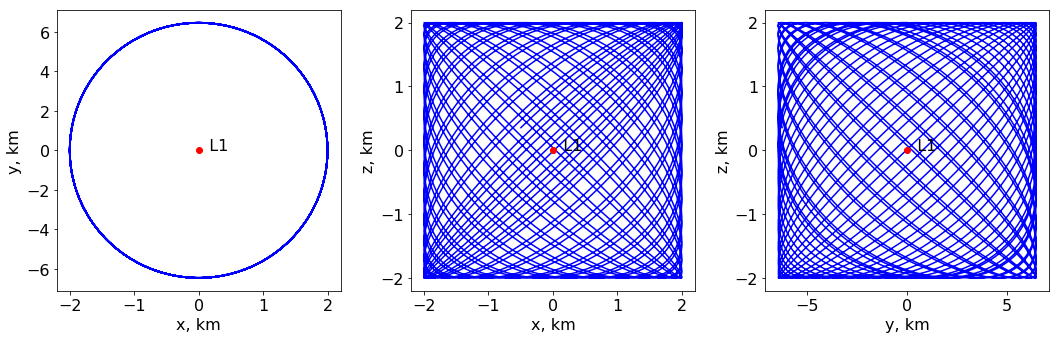

In [378]:
matplotlib.rcParams.update({'font.size': 16})
ax = plotter.plot_proj(temp,centers={'x': model.L1})
plotter.plot_proj(ax=ax, centers={'x': model.L1}, plottables=[plotter.L1], marker='o', color='r')
plt.tight_layout()
# plt.savefig('500_km_nonlin_example.png')

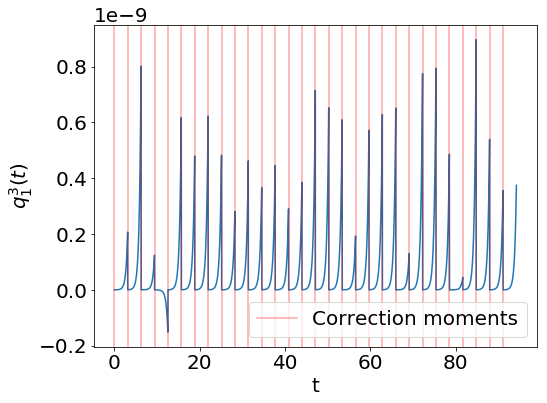

In [379]:
matplotlib.rcParams.update({'font.size': 20})
ctp.unst_comp_graph(temp, ctp.time_log)
plt.tight_layout()
# plt.savefig('500_km_nonlin_example_q1.png')

In [381]:
np.round(sum(np.abs(ctp.log)), 10)

9.07e-08

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efd525bea58>,
      dtype=object)

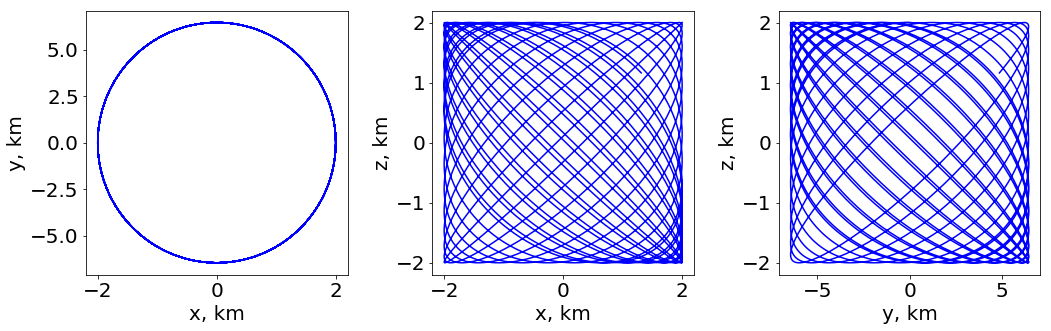

In [382]:
plotter.plot_proj(temp2,centers={'x': model.L1})

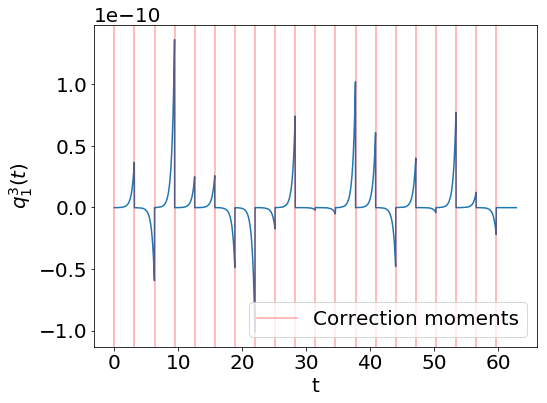

In [383]:
ctp.unst_comp_graph(temp2, cor_dvout[:,0])

In [384]:
np.round(sum(np.abs(cor_dvout[:,5])), 10)

9.01e-08

In [88]:
class LinUnstComp:
    def __init__(self):
        c2 = self.calc_c2()
        self.w1 = np.sqrt((-1.*c2+2+np.sqrt(9*c2**2-8*c2))/2)
        self.l1 = np.sqrt((c2-2+np.sqrt(9*c2**2-8*c2))/2)
        self.s1 = np.sqrt(2*self.l1*((4 + 3*c2)*self.l1**2 + 4 + 5*c2 - 6*c2**2))
        self.c2 = c2
        self.mu = model.mu
        self.gamma = 1.-model.mu-model.L1
        
    def apply_shift_scale(self, states):
        # 0-x 1-y 2-z 3-vx 4-vy 5-vz
        shift = (self.gamma+self.mu-1)/self.gamma
        states_new = states/self.gamma
        states_new[:,3] -= states[:,1]/self.gamma
        states_new[:,4] += states[:,0]/self.gamma
        states_new[:,0] += shift
        states_new[:,4] += shift
        return states_new
        
    def unst_comp_coef(self, states):
        new_states = self.apply_shift_scale(states.copy())
        x = new_states[:,0]
        y = new_states[:,1]
        px = new_states[:,3]
        py = new_states[:,4]
        return (1+2*self.c2)*(2*py + (-1 + 2*self.c2 + self.w1**2)*x) + self.l1*(px + 2*self.c2*px + px*self.w1**2 + y + 2*self.c2*y - y*self.w1**2)

    def calc_c2(self):
        r1 = np.abs(model.L1+model.mu)
        r2 = np.abs(model.L1+model.mu-1)
        
        return (1.-model.mu)/r1**3+model.mu/r2**3

In [188]:
class LinearProp:
    def __init__(self, model):
        self.model = model
        self.lin_unst = LinUnstComp()
        self.log = []
        self.time_log = []
        
    def target(self, dvy, state):
        s1 = state.copy()
        s1[4] += dvy
        return self.lin_unst.unst_comp_coef(np.array([s1]))[0]
        
    def correct(self, state):
        bound = self.bound(state)
        
        dvy = scp.optimize.bisect(self.target,-1.*bound, bound, xtol=1e-14, args=(state,))
        self.log.append(dvy)
        return dvy
    
    def bound(self, state):
        bound = 1e-10
        
        for i in range(10):
            if self.bound_crit(state, bound)<0:
                return bound
            else:
                bound*=10
        raise Exception('no root')
            
    def bound_crit(self, state, dv):
        val1 = self.target(dv, state)
        val2 = self.target(-1.*dv, state)
        return val1*val2
        
    
    def prop(self, dx, dz, N=10, time_step=np.pi):
        self.step = 0
        self.log = []
        self.time_log = []
        s0 = self.model.get_zero_state()
        s0[0] = self.model.L1 + dx
        s0[2] = dz
        result = []
        part, s0, t0 = self.prop_step(s0, 0.0, 0.0+time_step)
        result.append(part)
        for i in range(N-1):
            part, s0, t0 = self.prop_step(s0, t0, t0+time_step)
            result.append(part)
        return np.vstack(result)
        
    def prop_step(self, s0, t0, t1):
        s1 = s0.copy()
        s1[4] += self.correct(s1)
        self.time_log.append(t0)
        orb_part = self.model.prop(s1, t0, t1, ret_df = False)
        self.step+=1
        return orb_part[:-1], orb_part[-1][1:], orb_part[-1][0]
    
    def unst_comp_graph(self, orb, cor_times):
        orb_states = orb[:,1:].copy()
        orb_x3 = self.lin_unst.unst_comp_coef(orb_states)
        
        plt.figure(figsize=(8,6))
        plt.plot(orb[:,0], orb_x3)
        plt.xlabel('t')
        plt.ylabel('$q_1(t)$')
        for elem in cor_times:
            handle = plt.axvline(elem, color='r', alpha=0.35, label='Correction moments')
        plt.legend(handles=[handle], loc=4)
        plt.tight_layout()

In [274]:
lp = LinearProp(precise_model)

In [299]:
temp = lp.prop(3/model.R, 3/model.R, N=20)

In [300]:
temp2, cor_dvout  = calc_orb(3/model.R, 3/model.R)

Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efd52e78d68>,
      dtype=object)

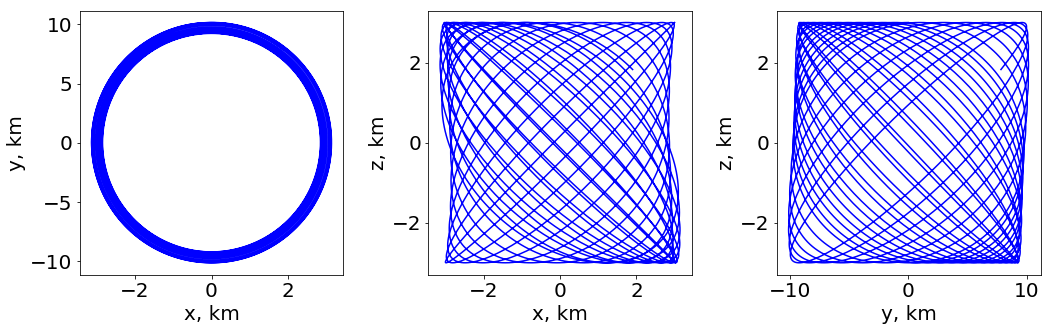

In [301]:
plotter.plot_proj(temp, centers={'x': model.L1})

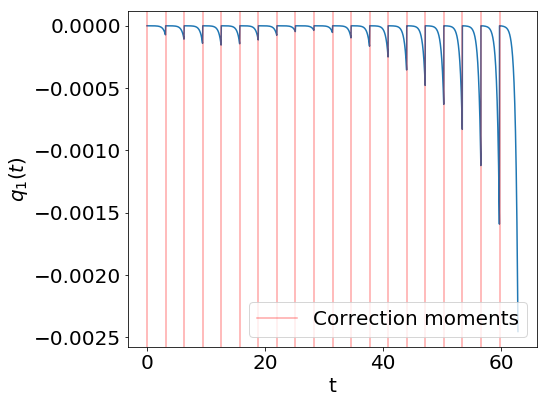

In [286]:
lp.unst_comp_graph(temp, lp.time_log)

In [287]:
lp.log

[-9.007108882069586e-07,
 4.1342264413833615e-08,
 6.123453974723816e-08,
 8.020351529121399e-08,
 8.840324282646179e-08,
 8.233062624931337e-08,
 6.488128304481506e-08,
 4.340443015098571e-08,
 2.6501923799514773e-08,
 2.1055537462234493e-08,
 3.0531173944473264e-08,
 5.526886582374572e-08,
 9.348602890968323e-08,
 1.4296165853738783e-07,
 2.0244019478559492e-07,
 2.7310296148061753e-07,
 3.5996410995721815e-07,
 4.7443392127752307e-07,
 6.402567848563194e-07,
 9.084827974438669e-07]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efd58c42588>,
      dtype=object)

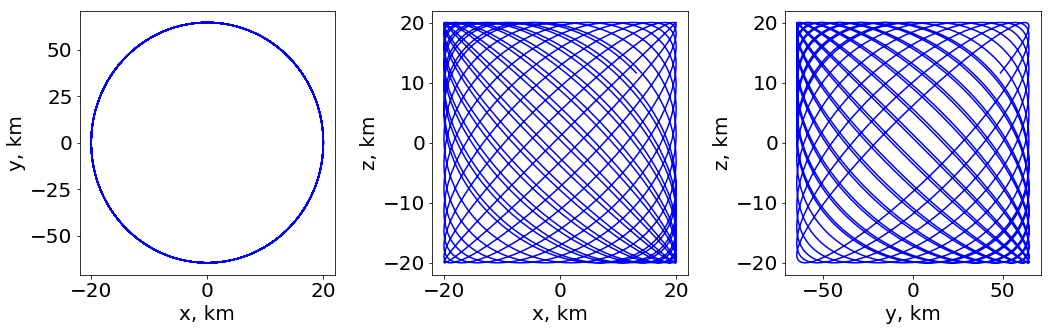

In [288]:
plotter.plot_proj(temp2, centers={'x': model.L1})

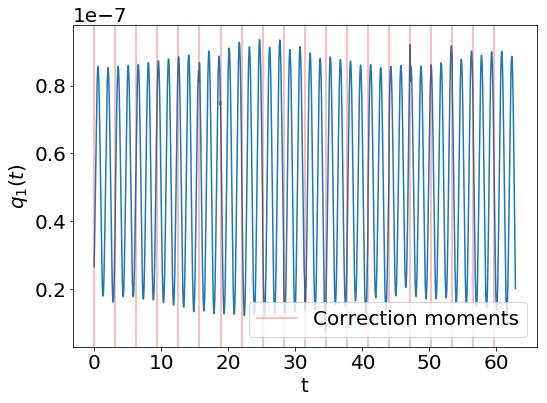

In [289]:
lp.unst_comp_graph(temp2, cor_dvout[:,0])

In [10]:
class EventQ1(op.base_event):
    def __init__(self, value, terminal, ct):
        self.ct = ct
        super().__init__(value=value, terminal=terminal)
    
    def __call__(self, t, s):
        q1 = self.ct.apply(np.array([s]))[0]
        return  q1 - self.value

In [11]:
class CTPropPlanes:
    def __init__(self, model, precise_model, formula_path):
        self.model = model
        ct = CT(model)
        symp_mat_inverse = np.linalg.inv(np.array(ct.R()).astype(np.float64))
        self.ct_x3 = CanonicTransform(formula_path, model, symp_mat_inverse)
        self.log = []
        self.time_log = []
        
    def target(self, dvy, state):
        s1 = state.copy()
        s1[4] += dvy
        return self.ct_x3.apply(np.array([s1]))[0]
        
    def correct(self, state):
        bound = self.bound(state)
        dvy = scp.optimize.bisect(self.target,-1.*bound, bound, xtol=1e-14, args=(state,))
        self.log.append(dvy)
        return dvy
    
    def bound(self, state):
        bound = 1e-13
        
        for i in range(13):
            if self.bound_crit(state, bound)<0:
                return bound
            else:
                bound*=10
        raise Exception('no root')
            
    def bound_crit(self, state, dv):
        val1 = self.target(dv, state)
        val2 = self.target(-1.*dv, state)
        return val1*val2
    
    def prop(self, s0, q1_min, q1_max, N=1):
        s_init = s0.copy()
        s_init[4] += self.correct(s_init)
        q1_left = EventQ1(q1_min, True, self.ct_x3)
        q1_right = EventQ1(q1_max, True, self.ct_x3)
        corr = op.border_correction(self.model, op.y_direction(), [q1_left], [q1_right])
        sk = op.simple_station_keeping(precise_model, corr, corr)
        df = sk.prop(0.0, s_init, N=N)
        return df, sk.dvout

In [47]:
ctp = CTPropPlanes(model, precise_model, '../unst_comp_calc/L1/x3_l1.bin')

In [48]:
s0 = model.get_zero_state()
s0[0] = model.L1 - 10000/model.R
s0[2] = 1000/model.R

In [49]:
df_res, dvout = ctp.prop(s0, -0.09, 0.09, N=5)

Simple station-keeping: 0 1 2 3 4 


<IPython.core.display.Javascript object>


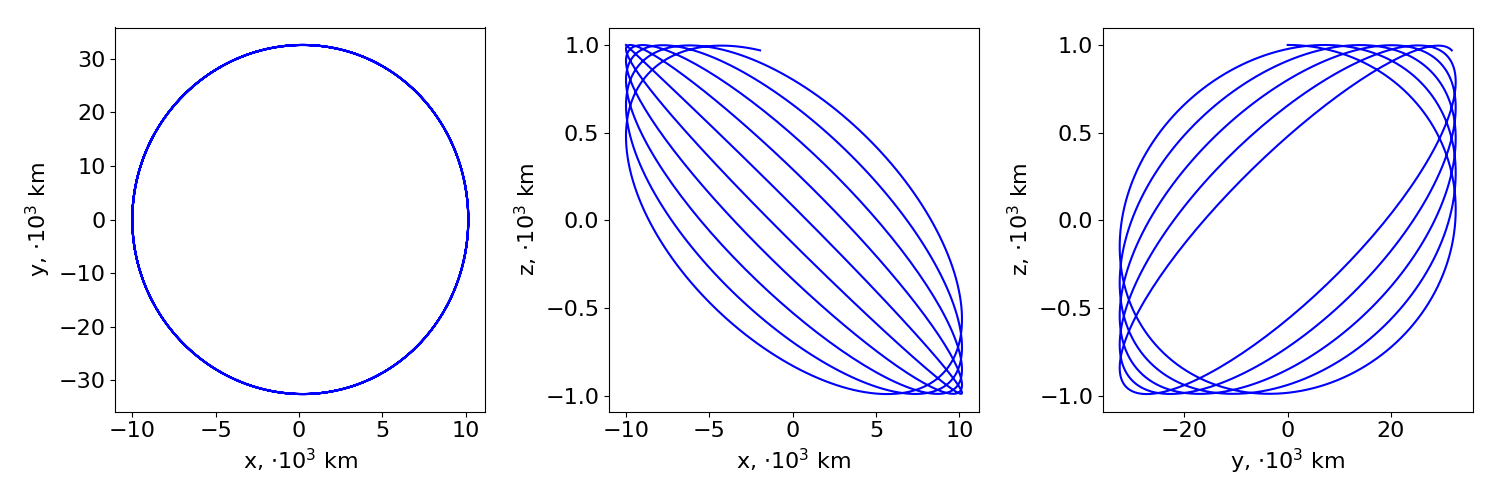

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe54d1ef6d8>,
      dtype=object)

In [50]:
plotter.plot_proj(df_res, centers={'x': model.L1})

In [421]:
dvout[:,5]

array([-1.76730007e-11,  6.61008060e-12,  5.19491732e-12,  2.21915543e-12,
        2.32808292e-12,  5.32381237e-12, -1.12646073e-11, -1.81531161e-11,
       -2.37113982e-11, -2.42998451e-11, -1.64435059e-11, -1.70341879e-11,
       -6.25051558e-12, -2.58065760e-12,  2.47798860e-12,  2.52343714e-12,
        2.58304179e-12, -8.70965421e-12, -1.08625740e-11, -2.00251490e-11])

In [16]:
def interactive_map(data, prop_name='Az-', diff=False):
    def onclick(event):
        if event.button == 3:
            ix, iy = event.xdata, event.ydata
            buffer.append([ix, iy])
            ax.plot(ix, iy, 'or')   
    fig = plt.figure(figsize=(8.4,7))
    ax = fig.add_subplot(111)
    color = data[prop_name]
    sc2 = ax.scatter(data['x0'], data['z0'], c=color, s=2.5, cmap='jet')
    ax.axis('equal')
    cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [51]:
map_data = pickle.load(open('amp_new.pkl','rb'))

<IPython.core.display.Javascript object>


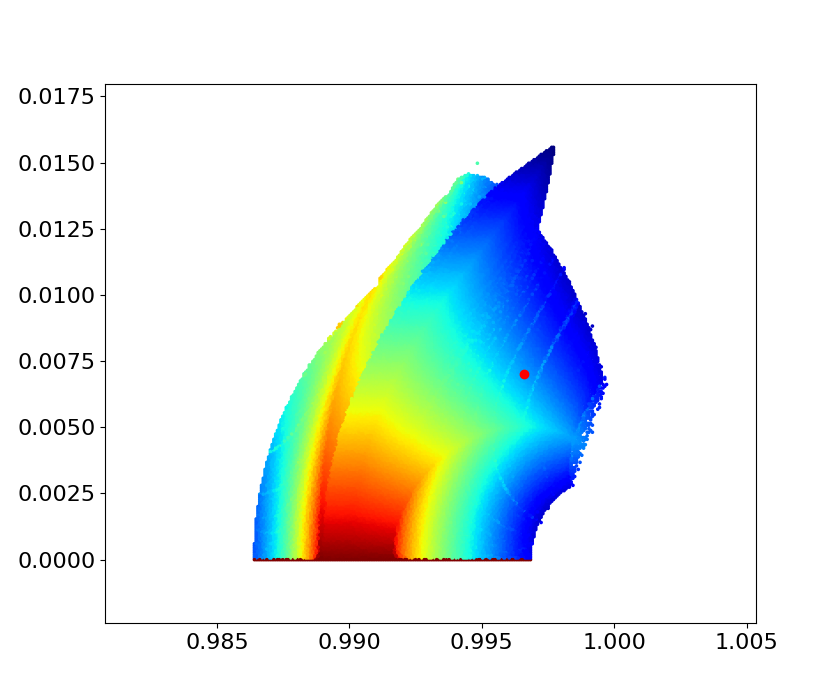

In [174]:
buffer = []
interactive_map(map_data, prop_name='Az-')

In [182]:
from mpl_toolkits.mplot3d import Axes3D

In [175]:
s0 = model.get_zero_state()
s0[0] = buffer[-1][0]
s0[2] = buffer[-1][1]
# s0 = model.get_zero_state()
# s0[0] = model.L1 + 3/model.R
# s0[2] = 3/model.R

In [171]:
# s0[4] += -0.014

In [176]:
df_res, dvout = ctp.prop(s0, -1, 1, N=5)

Simple station-keeping: 0 1 2 3 4 


In [149]:
dvs = np.linspace(-0.05, 0.05, 1000)
qs = [ctp.target(dv, s0) for dv in dvs]

In [ ]:
# a = array([1,1,-1,-2,-3,4,5])
# asign = np.sign(a)
# signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
# print signchange
# array([0, 0, 1, 0, 0, 1, 0])

<IPython.core.display.Javascript object>


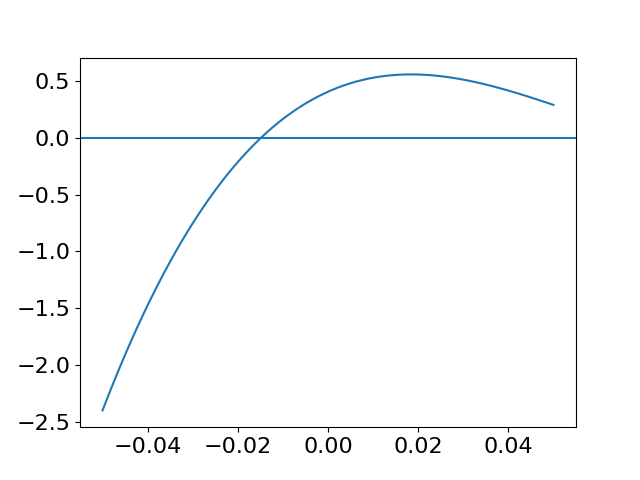

In [150]:
plt.plot(dvs, qs)
plt.axhline(0)

<IPython.core.display.Javascript object>


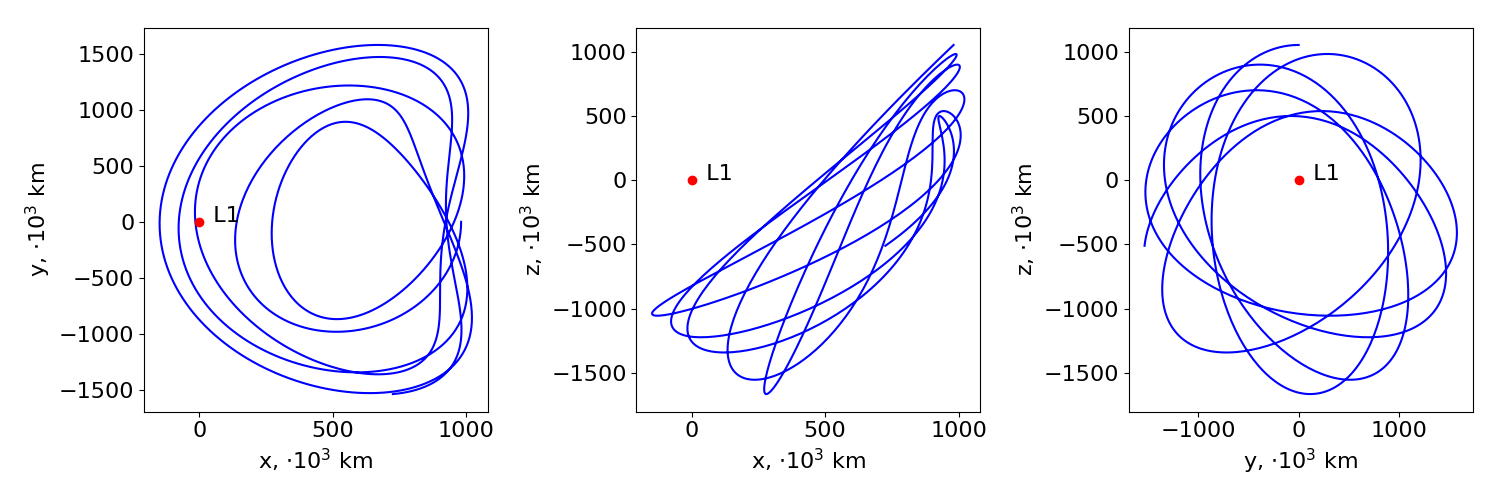

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe547d1b7b8>,
      dtype=object)

In [177]:
plotter = op.plotter.from_model(model, length_units='Mm', velocity_units='m/s')
matplotlib.rcParams.update({'font.size': 16})
ax = plotter.plot_proj(df_res, centers={'x': model.L1})
plotter.plot_proj(ax=ax, plottables=[plotter.L1], centers={'x': model.L1},color='r', marker='o')
# plt.savefig('ls.png')

In [265]:
!mv ls_3d.png /home/alex/Documents/csp2020/

In [262]:
def plot_3d(df, name= None):
    matplotlib.rcParams.update({'font.size': 13})
    df_scaled = df.copy()
    df_scaled['x'] -= model.L1
    df_scaled['x'] = scaler(df_scaled['x'], 'nd-Mm')
    df_scaled['y'] = scaler(df_scaled['y'], 'nd-Mm')
    df_scaled['z'] = scaler(df_scaled['z'], 'nd-Mm')
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(df_scaled['x'], df_scaled['y'], df_scaled['z'])
    ax.ticklabel_format(useOffset=False)
    ax.xaxis.labelpad=10
    ax.yaxis.labelpad=10
    ax.zaxis.labelpad=10
    plt.xlabel('$x, \cdot 10^3$ km')
    plt.ylabel('$y, \cdot 10^3$ km')
    ax.set_zlabel('$z, \cdot 10^3$ km')
    ax.view_init(29, -26)
#     for n, label in enumerate(ax.xaxis.get_ticklabels()):
#         if n % 2 != 0:
#             label.set_visible(False)

#     for n, label in enumerate(ax.yaxis.get_ticklabels()):
#         if n % 1 != 0:
#             label.set_visible(False)

#     for n, label in enumerate(ax.zaxis.get_ticklabels()):
#         if n % 2 != 0:
#             label.set_visible(False)
    if name != None:
        plt.savefig(name)

<IPython.core.display.Javascript object>


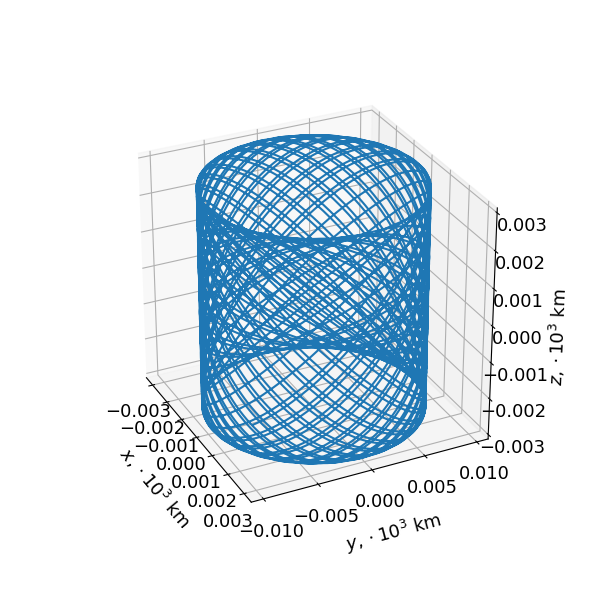

In [264]:
plot_3d(df_res, 'ls_3d.png')

In [287]:
lin_unst = LinUnstComp()
lin_unst_coef = lin_unst.unst_comp_coef(df_res.drop('t',axis=1).to_numpy())
nonlin_unst_coef = ctp.ct_x3.apply(df_res.drop('t',axis=1).to_numpy())

In [290]:
!mv unst_compare_v2.png /home/alex/Documents/csp2020/

<IPython.core.display.Javascript object>


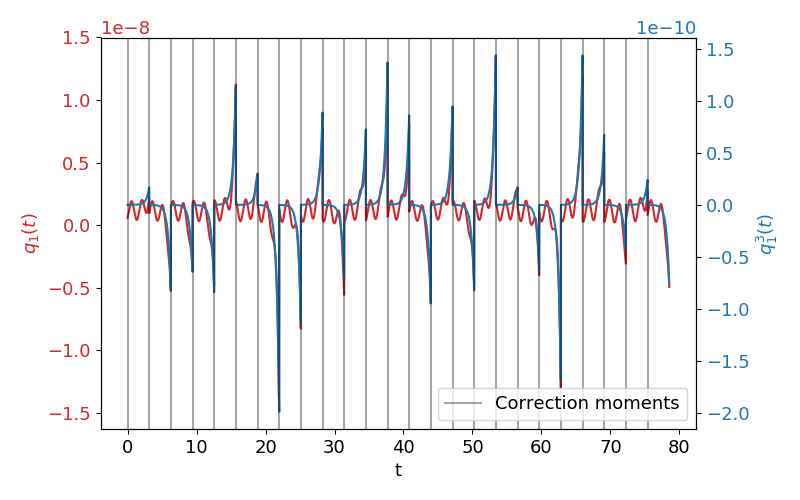

In [289]:
unst_comp_graph(df_res['t'], lin_unst_coef, nonlin_unst_coef, dvout)
plt.savefig('unst_compare_v2.png')

In [92]:
s0 = model.get_zero_state()
s0[0] = model.L1 + 1/model.R
s0[2] = 1/model.R

In [93]:
df_res2, dvout2 = ctp.prop(s0, -1, 1, N=30)

Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 


<IPython.core.display.Javascript object>


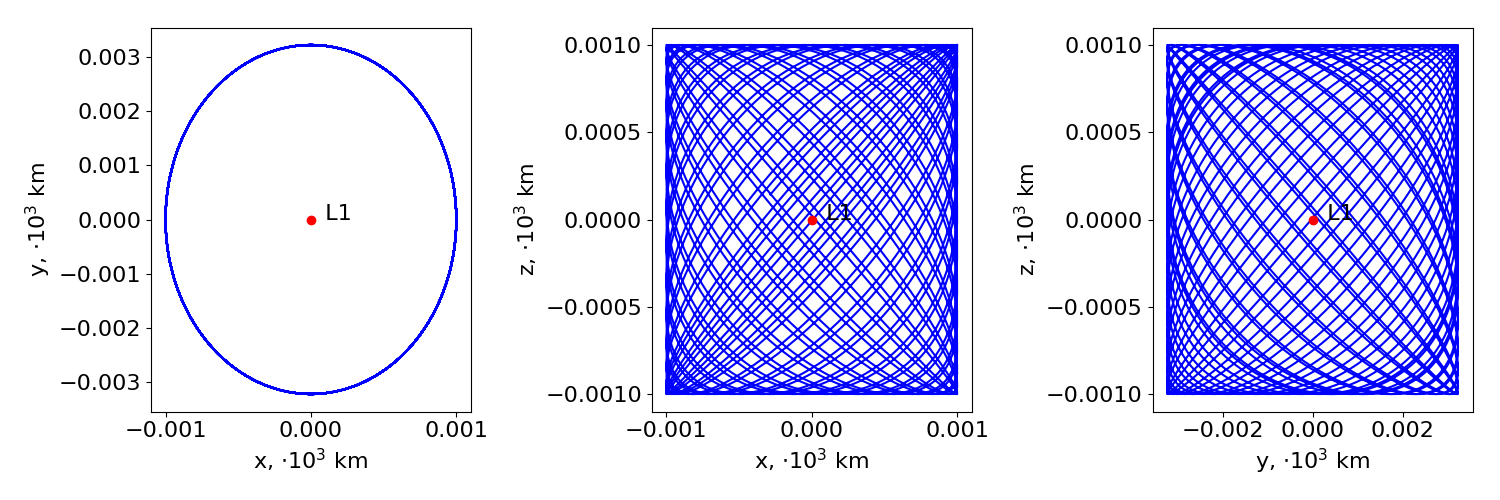

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2ed2527b8>,
      dtype=object)

In [94]:
plotter = op.plotter.from_model(model, length_units='Mm', velocity_units='m/s')
matplotlib.rcParams.update({'font.size': 16})
ax = plotter.plot_proj(df_res2, centers={'x': model.L1})
plotter.plot_proj(ax=ax, plottables=[plotter.L1], centers={'x': model.L1},color='r', marker='o')
# plt.savefig('ls.png')

In [124]:
lin_unst = LinUnstComp()
lin_unst_coef = lin_unst.unst_comp_coef(df_res.drop('t',axis=1).to_numpy())
lin_unst_coef2 = lin_unst.unst_comp_coef(df_res2.drop('t',axis=1).to_numpy())

In [125]:
nonlin_unst_coef = ctp.ct_x3.apply(df_res.drop('t',axis=1).to_numpy())
nonlin_unst_coef2 = ctp.ct_x3.apply(df_res2.drop('t',axis=1).to_numpy())

In [165]:
def unst_comp_graph(time, lin_unst, nonlin_unst, cor_times=[]):
    fig, ax1 = plt.subplots(figsize=(8,5))

    ax1.set_xlabel('t')
    ax1.set_ylabel('$q_1(t)$', color='tab:red')
    ax1.plot(time, lin_unst, color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('$q_1^3(t)$', color='tab:blue')
    ax2.plot(time, nonlin_unst, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    
    if cor_times.any():
        for elem in cor_times:
            handle = plt.axvline(elem[0], color='k', alpha=0.35, label='Correction moments')
        plt.legend(handles=[handle], loc=4)

    fig.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


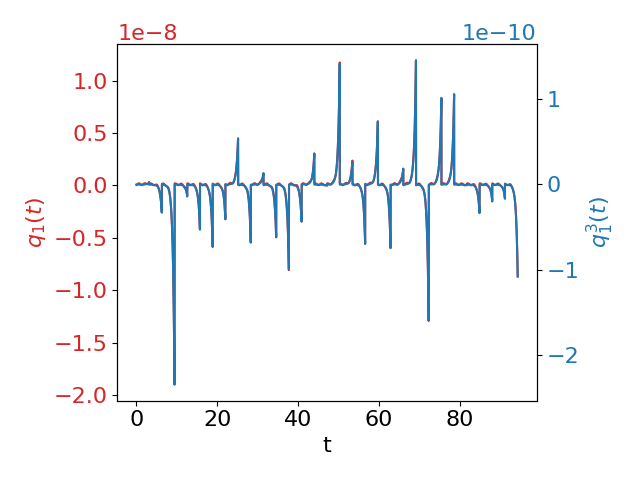

In [127]:
unst_comp_graph(df_res2['t'], lin_unst_coef2, nonlin_unst_coef2)

<IPython.core.display.Javascript object>


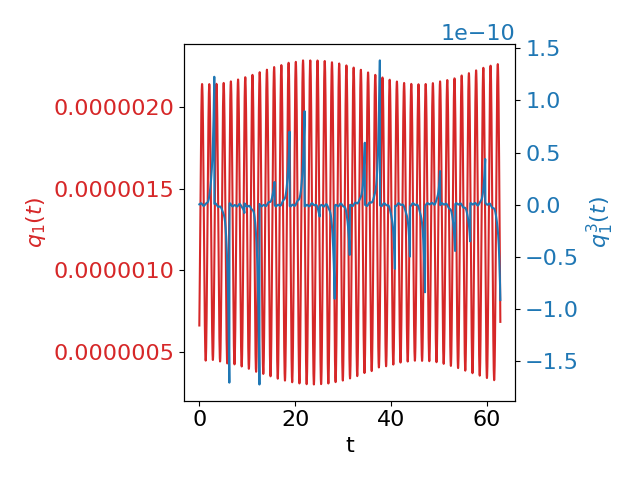

In [128]:
unst_comp_graph(df_res['t'], lin_unst_coef, nonlin_unst_coef)

In [266]:
class EventQ1Lin(op.base_event):
    def __init__(self, value, terminal):
        self.lin_unst = LinUnstComp()
        super().__init__(value=value, terminal=terminal)
    
    def __call__(self, t, s):
        q1 = self.lin_unst.unst_comp_coef(np.array([s]))[0]
        return  q1 - self.value

In [267]:
class LinPropPlanes:
    def __init__(self, model, precise_model):
        self.model = model
        self.lin_unst = LinUnstComp()
        self.log = []
        self.time_log = []
        
    def target(self, dvy, state):
        s1 = state.copy()
        s1[4] += dvy
        return self.lin_unst.unst_comp_coef(np.array([s1]))[0]
        
    def correct(self, state):
        bound = self.bound(state)
        dvy = scp.optimize.bisect(self.target,-1.*bound, bound, xtol=1e-14, args=(state,))
        self.log.append(dvy)
        return dvy
    
    def bound(self, state):
        bound = 1e-13
        
        for i in range(13):
            if self.bound_crit(state, bound)<0:
                return bound
            else:
                bound*=10
        raise Exception('no root')
            
    def bound_crit(self, state, dv):
        val1 = self.target(dv, state)
        val2 = self.target(-1.*dv, state)
        return val1*val2
    
    def prop(self, s0, q1_min, q1_max, N=1):
        s_init = s0.copy()
        s_init[4] += self.correct(s_init)
        q1_left = EventQ1Lin(q1_min, True)
        q1_right = EventQ1Lin(q1_max, True)
        corr = op.border_correction(self.model, op.y_direction(), [q1_left], [q1_right])
        sk = op.simple_station_keeping(precise_model, corr, corr)
        df = sk.prop(0.0, s_init, N=N)
        return df, sk.dvout

In [269]:
test_lin = LinPropPlanes(model, precise_model)

In [279]:
s0 = model.get_zero_state()
# s0[0] = model.L1 + 1000/model.R
# s0[2] = 1000/model.R
s0[0] = buffer[-1][0]
s0[2] = buffer[-1][1]

In [281]:
df_res3, dvout3 = test_lin.prop(s0, -2, 2, N=5)

Simple station-keeping: 

RuntimeError: Borders unreachable

<IPython.core.display.Javascript object>


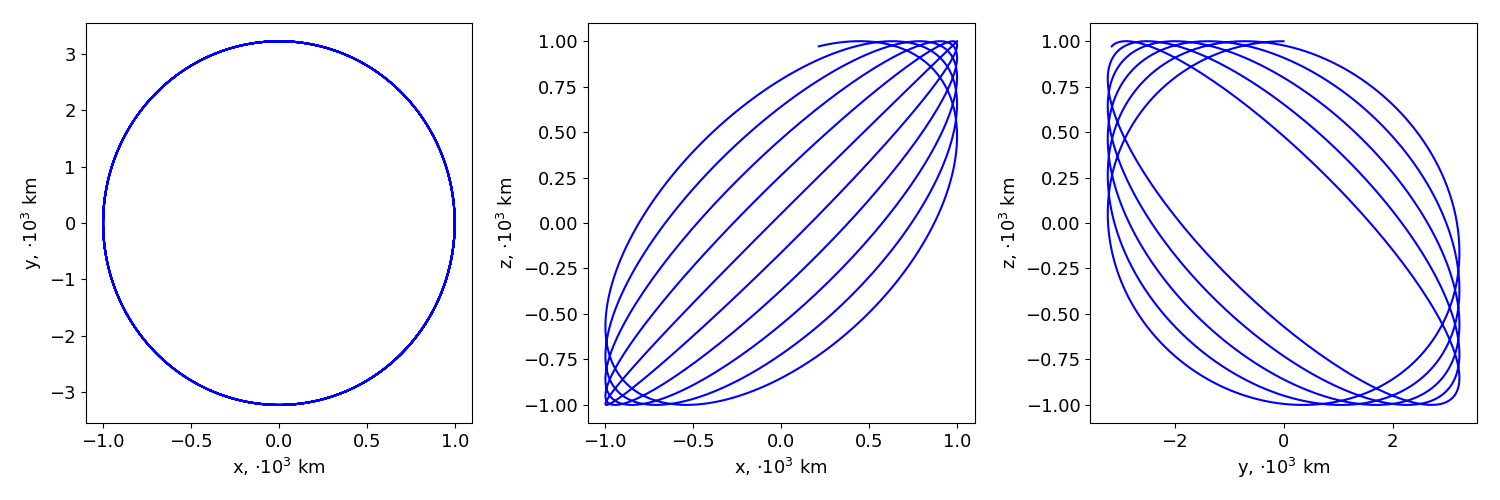

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2ce759c18>,
      dtype=object)

In [278]:
plotter.plot_proj(df_res3, centers={'x': model.L1})